# Example usage of sqrt UKF

This example uses a sqrt UKF to solve a nonlinear observability problem, as described in great detail here: https://iopscience.iop.org/article/10.1088/1748-3182/9/2/025002/meta

The UKF in this package implements the matlab version cited by that paper. The original matlab UKF was written by Nathan Powell, and can be found here: https://github.com/florisvb/dyneye/tree/master/Analysis/Matlab

In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

In [2]:
import ukf_sqrt.ukf_sqrt as ukf_sqrt

# Load data

In [3]:
mat = scipy.io.loadmat('dyneye_data.mat')

In [4]:
R = mat['R']
Q = mat['Q']
d = mat['position']
v = mat['velocity']
u = mat['control']
t = mat['time']
dt = mat['dt']
flow = mat['optic_flow']
x0 = np.matrix([[10], [-1]])

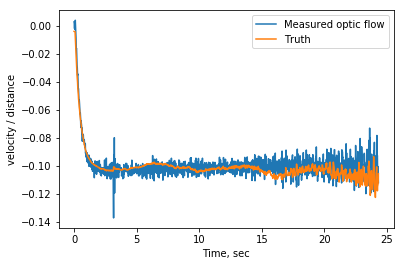

In [5]:
plt.plot(t, flow, label='Measured optic flow')
plt.plot(t, v/d, label='Truth')

plt.xlabel('Time, sec')
plt.ylabel('velocity / distance')

plt.legend()

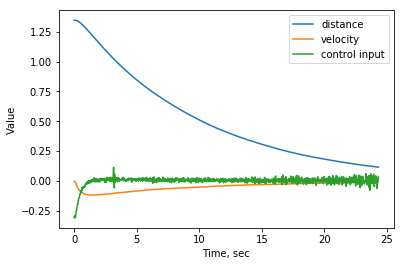

In [6]:
plt.plot(t, d, label='distance')
plt.plot(t, v, label='velocity')
plt.plot(t, u, label='control input')

plt.xlabel('Time, sec')
plt.ylabel('Value')

plt.legend()

# Reformat the measurements and controls

In [7]:
# the measurements
y = np.matrix(flow).T
print(y.shape)

# how many measurements are there?
N = y.shape[1]

(1, 1217)


In [8]:
# the controls (no control)
u = np.matrix(u).T
print(u.shape)

(1, 1217)


# Define measurement and process nonlinear dynamics

In [9]:
# measurement dynamics
def h(x, u, w):
    y = np.vstack((x[1,:]/x[0,:] + w[0, :]))
    return y

In [10]:
# process dynamics
def f(x, u, w=None):
    d, v = np.ravel(x[:,-1])
    u = np.ravel(u[:,-1])
    xhat = np.vstack((d + v*dt,
                      v + u*dt))
    return xhat

# Make R and Q functions of time

In [11]:
# process covariance
# make it a 3D matrix in time
Qt = np.tile(np.expand_dims(Q, 2), N)

# measurement covariance
# make it a 3D matrix in time
Rt = np.tile(np.expand_dims(R, 2), N)

In [12]:
type(Qt)

numpy.ndarray

# Run the UKF

In [13]:
print(y.shape, x0.shape, Qt.shape, Rt.shape, u.shape)

(1, 1217) (2, 1) (2, 2, 1217) (1, 1, 1217) (1, 1217)


In [14]:
xhat, P, s = ukf_sqrt(y, x0, f, h, Qt, Rt, u, alpha=0.001, beta=2)

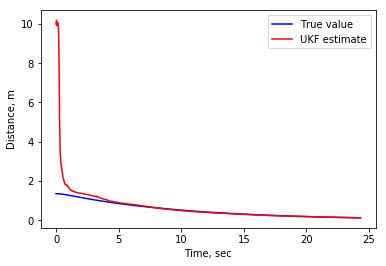

In [15]:
plt.plot(t, d, color='blue', label='True value')
plt.plot(t, xhat[0,:].T, color='red', label='UKF estimate')

plt.xlabel('Time, sec')
plt.ylabel('Distance, m')

plt.legend()

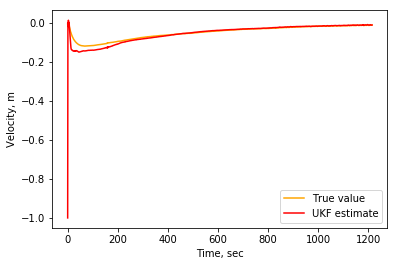

In [16]:
plt.plot(v, color='orange', label='True value')
plt.plot(xhat[1,:].T, color='red', label='UKF estimate')

plt.xlabel('Time, sec')
plt.ylabel('Velocity, m')

plt.legend()

Text(0,0.5,'Covariance')

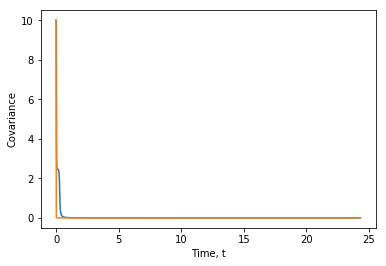

In [17]:
plt.plot(t, P[0,0,:].T)
plt.plot(t, P[1,1,:].T)

plt.xlabel('Time, t')
plt.ylabel('Covariance')